In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import sys
import matplotlib as mpl
from matplotlib.colors import LogNorm
import icomo
import diffrax

sys.path.append("../src/")
from tapm import utils

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
args, y0 = utils.read_params(filename="model_params_HIVandSTI.txt")
lambdaP = 1 / 360  # 1,2,4
betaSTI = 0.008  # 0.0016 *[3, 5, 7]

In [3]:
T = 365*20
ts = np.linspace(0, T, T)
y0 = {
    "S": 0.99,  # Initial susceptible proportion
    "Ia": 0.009,  # Initial asymptomatic proportion
    "Is": 0.001,  # Initial symptomatic proportion
}


integrator = icomo.ODEIntegrator( # integrates ODE system
    ts_out=ts, # time points for output
    t_0=ts[0], # from time 0
    t_1=ts[-1], # to time T
    ts_solver=ts, # time points for solving the ODE
    ts_arg=ts, # time points for time-dependent argument
    interp="cubic", # interpolation method
    solver=diffrax.Bosh3(),  # a 3rd order method
    adjoint=diffrax.RecursiveCheckpointAdjoint(checkpoints=len(ts)),
    max_steps=10000,
)

def lambdas(P, H):
    return args["lambda_s"] + lambdaa(P, H)
def lambdaa(P, H):
    return lambdaH(P, H) * (1 - P) + lambdaP * P
def lambdaH(P, H):
    return args["c"] * (1 - m(P, H)) * args["beta_HIV"] * H
def m(P, H):
    return args["min_exp"] + (args["max_exp"] - args["min_exp"]) * (1 - jnp.exp(-H / args["tau_exp"]))

# ODE system
def SIaIsS(t, y, arguments):
    β, args = arguments # beta is time-dependent argument, other args are constant
    P = args["P"]
    H = args["H"]
    # ODEs
    Lambda = args['beta_STI'] * (1-m(P,H)*(1-P)) * (y["Ia"] + y["Is"]) 
    dS = -Lambda * y["S"] + args['gamma_STI'] * y["Ia"] + args['gammaT_STI'] * (1-y["Is"]-y["Ia"]-y["S"]) + args['mu'] - args['mu'] * y["S"] - args['Sigma']
    dIa = args['psi'] * Lambda * y["S"] -  args['gamma_STI'] * y["Ia"] - lambdaa(P,H)*y["Ia"] - args['mu'] * y["Ia"] + args['psi'] *args['Sigma']
    dIs = (1-args['psi']) * Lambda * y["S"] - lambdas(P,H)*y['Is'] - args['mu'] * y["Is"] + (1-args['psi']) * args['Sigma']
    dy = {"S": dS, "Ia": dIa, "Is": dIs}
    return dy

SIRS_integrator = integrator.get_func(SIaIsS) # give ODE system to integrator
const_args = args

Ps = np.linspace(0, 1, 10)
Hs = np.linspace(0, 0.2, 10)




## Fixed points calculation (Laura new)

In [4]:
def f(P,H):
    return (lambdas(P,H)+args["mu"]) / (1-args["psi"])

def Splus(P,H):
    return (f(P,H)*Iaplus(P,H)*c(P,H)-args['Sigma']) / (kappa(P,H)*Iaplus(P,H)*(1+c(P,H)))
    
def Sminus(P,H):
    return (f(P,H)*Iaminus(P,H)*c(P,H)-args['Sigma']) / (kappa(P,H)*Iaminus(P,H)*(1+c(P,H)))
    
def c(P,H):
    return ((1-args['psi'])*(args['gamma_STI']+lambdaa(P,H)+args['mu'])) / (args['psi']*(lambdas(P,H)+args['mu']))

def Iaplus(P,H):
    return (-bL(P,H) + np.sqrt(bL(P,H)**2 - 4*aL(P,H)*dL(P,H))) / (2*aL(P,H))

def Iaminus(P,H):
    return (-bL(P,H) - np.sqrt(bL(P,H)**2 - 4*aL(P,H)*dL(P,H))) / (2*aL(P,H))

def aL(P,H):
    return kappa(P,H) * (args['gamma_STI']-args['gammaT_STI']+c(P,H)**2*(-f(P,H)-args['gammaT_STI'])+c(P,H)*(-f(P,H)+args['gamma_STI']-2*args['gammaT_STI']))

def bL(P,H):
    return kappa(P,H)*(args['gammaT_STI']+args['mu'])*(1+c(P,H))+c(P,H)*(args['mu']-args['gammaT_STI'])*f(P,H)

def dL(P,H):
    return args['Sigma']*(args['mu']-args['gammaT_STI'])

def kappa(P,H):
    return args['beta_STI'] * (1-m(P,H)*(1-P))
def lambdas(P, H):
    return args["lambda_s"] + lambdaa(P, H)
def lambdaa(P, H):
    return lambdaH(P, H) * (1 - P) + lambdaP * P
def lambdaH(P, H):
    return args["c"] * (1 - m(P, H)) * args["beta_HIV"] * H
def m(P, H):
    return args["min_exp"] + (args["max_exp"] - args["min_exp"]) * (1 - jnp.exp(-H / args["tau_exp"]))
def R0(P, H):
    return args["psi"] * (args['beta_STI'] * (1 - m(P, H) * (1 - P))) / (args["gamma_STI"] + lambdaa(P, H) + args["mu"]) + (1 - args["psi"]) * (args['beta_STI'] * (1 - m(P, H) * (1 - P))) / (lambdas(P, H) + args["mu"])

Ps = np.linspace(0, 1, 10)
Hs = np.linspace(0, 0.2, 10)


laura_Ia = np.zeros((len(Ps), len(Hs)))
laura_Is = np.zeros((len(Ps), len(Hs)))
laura_S = np.zeros((len(Ps), len(Hs)))
numres_Ia = np.zeros((len(Ps), len(Hs)))
numres_Is = np.zeros((len(Ps), len(Hs)))
numres_S = np.zeros((len(Ps), len(Hs)))
for i,P in enumerate(Ps):
    for j,H in enumerate(Hs):
        const_args["P"] = P
        const_args["H"] = H
        output = SIRS_integrator(y0=y0, arg_t=np.ones(T), constant_args=const_args)
        numres_Ia[i,j] = output['Ia'][-1]
        numres_Is[i,j] = output['Is'][-1]
        numres_S[i,j] = output['S'][-1]
        laura_Ia[i,j] = Iaplus(P,H)
        laura_Is[i,j] = c(P,H)*Iaplus(P,H)
        laura_S[i,j] = Splus(P,H)
        if False:#R0(P,H) < 1:
            print("---------P: ",P," H: ",H)
            # sol from sim
            print("Ia:", output['Ia'][-1], "Is: ", output['Is'][-1],"S:", output['S'][-1])
            # sol from formula
            #print("Iaplus:", Iaplus(P,H), "Is: ", c(P,H)*Iaplus(P,H),"Splus:", Splus(P,H))
            #print("..Iaminus:", args['psi']*((args['Sigma'])/(args['gammaT_STI']+args['mu'])), "Is: ", (1-args['psi'])*((args['Sigma'])/(args['gammaT_STI']+args['mu'])), "Sminus:", 1-(args['Sigma'])/(args['gammaT_STI']+args['mu']))
            print("Iaminus:", Iaminus(P,H), "Is: ", c(P,H)*Iaminus(P,H), "Sminus:", Sminus(P,H))


#const_args["P"] = 0.8888888888888888
#const_args["H"] = 0.15555555555555556
#output = SIRS_integrator(y0=y0, arg_t=np.ones(T), constant_args=const_args)
#print("---------P: ",P," H: ",H)
#plt.plot(output['Ia'])



INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


## Final 3X3 Figure

In [5]:
def kappa(P, H, args):
    return args['beta_STI'] * (1 - m(P, H, args) * (1 - P))

def lambdas(P, H, args, lambda_P):
    return args["lambda_s"] + lambdaa(P, H, args, lambda_P)

def lambdaa(P, H, args, lambda_P):
    return lambdaH(P, H, args) * (1 - P) + lambda_P * P

def lambdaH(P, H, args):
    return args["c"] * (1 - m(P, H, args)) * args["beta_HIV"] * H

def m(P, H, args):
    return args["min_exp"] + (args["max_exp"] - args["min_exp"]) * (1 - np.exp(-H / args["tau_exp"]))

def calculate_Ia(P, H, args, lambda_P):
    gamma, tilde_gamma, mu, psi, Sigma = args["gamma_STI"], args["gammaT_STI"], args["mu"], args["psi"], args["Sigma"]
    kappa_val = kappa(P, H, args)
    lambda_s_val = lambdas(P, H, args, lambda_P)
    lambda_a_val = lambdaa(P, H, args, lambda_P)

    C = (gamma + lambda_a_val + mu) * (1 - psi) / (psi * (lambda_s_val + mu))
    A = kappa_val * (1 + C) * (-(lambda_s_val + mu) * C + (gamma - tilde_gamma * (1 + C)) * (1 - psi))
    B = (tilde_gamma + mu) * ((1 - psi) * kappa_val * (1 + C) - (lambda_s_val + mu) * C)
    D = (tilde_gamma + mu) * (1 - psi) * Sigma

    discriminant = B**2 - 4 * A * D
    if discriminant < 0:
        raise ValueError("Discriminant is negative, no real roots exist.")

    Ia_star = (-B - np.sqrt(discriminant)) / (2 * A)

    return Ia_star

def calculate_Is(P, H, args, lambda_P):
    gamma, tilde_gamma, mu, psi, Sigma = args["gamma_STI"], args["gammaT_STI"], args["mu"], args["psi"], args["Sigma"]
    kappa_val = kappa(P, H, args)
    lambda_s_val = lambdas(P, H, args, lambda_P)
    lambda_a_val = lambdaa(P, H, args, lambda_P)

    C = (gamma + lambda_a_val + mu) * (1 - psi) / (psi * (lambda_s_val + mu))
    A = kappa_val * (1 + C) * (-(lambda_s_val + mu) * C + (gamma - tilde_gamma * (1 + C)) * (1 - psi))
    B = (tilde_gamma + mu) * ((1 - psi) * kappa_val * (1 + C) - (lambda_s_val + mu) * C)
    D = (tilde_gamma + mu) * (1 - psi) * Sigma

    discriminant = B**2 - 4 * A * D
    if discriminant < 0:
        raise ValueError("Discriminant is negative, no real roots exist.")

    Ia_star = (-B - np.sqrt(discriminant)) / (2 * A)
    Is_star = C * Ia_star

    return Is_star

def calculate_S(P, H, args, lambda_P):
    gamma, tilde_gamma, mu, psi, Sigma = args["gamma_STI"], args["gammaT_STI"], args["mu"], args["psi"], args["Sigma"]
    kappa_val = kappa(P, H, args)
    lambda_s_val = lambdas(P, H, args, lambda_P)
    lambda_a_val = lambdaa(P, H, args, lambda_P)

    C = (gamma + lambda_a_val + mu) * (1 - psi) / (psi * (lambda_s_val + mu))
    A = kappa_val * (1 + C) * (-(lambda_s_val + mu) * C + (gamma - tilde_gamma * (1 + C)) * (1 - psi))
    B = (tilde_gamma + mu) * ((1 - psi) * kappa_val * (1 + C) - (lambda_s_val + mu) * C)
    D = (tilde_gamma + mu) * (1 - psi) * Sigma

    discriminant = B**2 - 4 * A * D
    if discriminant < 0:
        raise ValueError("Discriminant is negative, no real roots exist.")

    Ia_star = (-B - np.sqrt(discriminant)) / (2 * A)
    S_star = ((lambda_s_val + mu) * C * Ia_star - (1 - psi) * Sigma) / ((1 - psi) * kappa_val * (1 + C) * Ia_star)

    return S_star

def R0(P, H, args, lambda_P):
    return args["psi"] * (args['beta_STI'] * (1 - m(P, H, args) * (1 - P))) / (args["gamma_STI"] + lambdaa(P, H, args, lambda_P) + args["mu"]) + (1 - args["psi"]) * (args['beta_STI'] * (1 - m(P, H, args) * (1 - P))) / (lambdas(P, H, args, lambda_P) + args["mu"])


Piklu: P 0.0 H 0.044444444444444446 Ia diff: 0.014504117704288014 Is diff: 0.00017761545124741595 S diff: -0.0150928547126985
Piklu: P 0.1111111111111111 H 0.044444444444444446 Ia diff: 0.017077907284746327 Is diff: 0.000201004997682596 S diff: -0.017754539054888885
Piklu: P 0.2222222222222222 H 0.044444444444444446 Ia diff: 0.010641335855586603 Is diff: 0.00011886720222104865 S diff: -0.011050714809247464
Piklu: P 0.3333333333333333 H 0.044444444444444446 Ia diff: 0.004750954557014422 Is diff: 5.021741534099594e-05 S diff: -0.004928249965733489
Piklu: P 0.4444444444444444 H 0.044444444444444446 Ia diff: 0.0017764342093857521 Is diff: 1.777175469873816e-05 S diff: -0.0018407644856071048
Piklu: P 0.4444444444444444 H 0.06666666666666667 Ia diff: 0.0014520284125510916 Is diff: 1.9396767257934543e-05 S diff: -0.0015179123186631616
Piklu: P 0.5555555555555556 H 0.044444444444444446 Ia diff: 0.0006024514190650643 Is diff: 5.6992873546561976e-06 S diff: -0.0006236205832906849
Piklu: P 0.5555

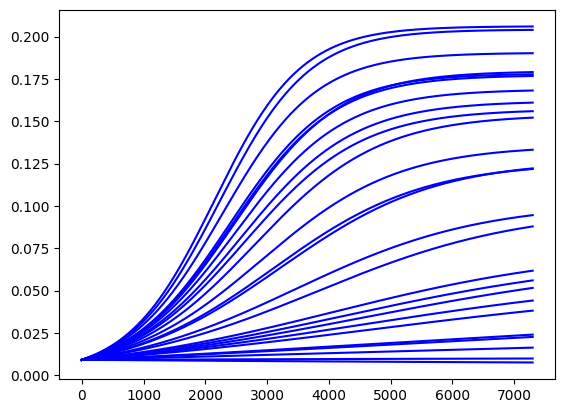

In [6]:
Ps = np.linspace(0, 1, 10)
Hs = np.linspace(0.0, 0.2, 10)
laura_count = 0
piklu_count = 0
for i,P in enumerate(Ps):
    for j,H in enumerate(Hs):
        lambdaP = 1 / 360
        if R0(P, H, args, lambdaP) > 1:
            Ia_star, Is_star, S_star = calculate_Ia(P, H, args, lambdaP), calculate_Is(P, H, args, lambdaP), calculate_S(P, H, args, lambdaP)
            #print("P",P,"H",H,"Ia*:", Ia_star, "Is*:", Is_star, "S*:", S_star)
            #print("Ia:", numres_Ia[i,j], "Is:", numres_Is[i,j], "S:", numres_S[i,j])
            # difference
            if abs(Ia_star - numres_Ia[i,j]) > 0.0001:
                piklu_count += 1
                print("Piklu: P",P,"H",H,"Ia diff:", Ia_star - numres_Ia[i,j], "Is diff:", Is_star - numres_Is[i,j], "S diff:", S_star - numres_S[i,j])
                const_args["P"] = P
                const_args["H"] = H
                output = SIRS_integrator(y0=y0, arg_t=np.ones(T), constant_args=const_args)
                plt.plot(output['Ia'], color='blue')
            if False:#abs(laura_Ia[i,j] - numres_Ia[i,j]) > 0.001:
                laura_count += 1
                print("Laura: P",P,"H",H,"Ia diff:", laura_Ia[i,j] - numres_Ia[i,j], "Is diff:", laura_Is[i,j] - numres_Is[i,j], "S diff:", laura_S[i,j] - numres_S[i,j])
                const_args["P"] = P
                const_args["H"] = H
                output = SIRS_integrator(y0=y0, arg_t=np.ones(T), constant_args=const_args)
                plt.plot(output['Ia'], color='red')
print("Piklu count:", piklu_count)
print("Laura count:", laura_count)


In [3]:
import numpy as np

def kappa(P, H, args):
    return args['beta_STI'] * (1 - m(P, H, args) * (1 - P))

def lambdas(P, H, args, lambda_P):
    return args["lambda_s"] + lambdaa(P, H, args, lambda_P)

def lambdaa(P, H, args, lambda_P):
    return lambdaH(P, H, args) * (1 - P) + lambda_P * P

def lambdaH(P, H, args):
    return args["c"] * (1 - m(P, H, args)) * args["beta_HIV"] * H

def m(P, H, args):
    return args["min_exp"] + (args["max_exp"] - args["min_exp"]) * (1 - np.exp(-H / args["tau_exp"]))

def calculate_Ia(P, H, args, lambda_P):
    gamma, tilde_gamma, mu, psi, Sigma = args["gamma_STI"], args["gammaT_STI"], args["mu"], args["psi"], args["Sigma"]
    kappa_val = kappa(P, H, args)
    lambda_s_val = lambdas(P, H, args, lambda_P)
    lambda_a_val = lambdaa(P, H, args, lambda_P)

    C = (gamma + lambda_a_val + mu) * (1 - psi) / (psi * (lambda_s_val + mu))
    A = gamma - (1 - psi) * (lambda_s_val + mu) * C - tilde_gamma * (1 + C)
    B = tilde_gamma + mu - ((tilde_gamma + mu) * (lambda_s_val + mu) * C) / ((1 - psi) * kappa_val * (1 + C))
    C_prime = (tilde_gamma + mu) * Sigma / (kappa_val * (1 + C))

    discriminant = B**2 - 4 * A * C_prime
    if discriminant < 0:
        raise ValueError("Discriminant is negative, no real roots exist.")

    Ia_star = (-B - np.sqrt(discriminant)) / (2 * A)

    return Ia_star

def calculate_Is(P, H, args, lambda_P):
    gamma, tilde_gamma, mu, psi, Sigma = args["gamma_STI"], args["gammaT_STI"], args["mu"], args["psi"], args["Sigma"]
    kappa_val = kappa(P, H, args)
    lambda_s_val = lambdas(P, H, args, lambda_P)
    lambda_a_val = lambdaa(P, H, args, lambda_P)

    C = (gamma + lambda_a_val + mu) * (1 - psi) / (psi * (lambda_s_val + mu))
    A = gamma - (1 - psi) * (lambda_s_val + mu) * C - tilde_gamma * (1 + C)
    B = tilde_gamma + mu - ((tilde_gamma + mu) * (lambda_s_val + mu) * C) / ((1 - psi) * kappa_val * (1 + C))
    C_prime = (tilde_gamma + mu) * Sigma / (kappa_val * (1 + C))

    discriminant = B**2 - 4 * A * C_prime
    if discriminant < 0:
        raise ValueError("Discriminant is negative, no real roots exist.")

    Ia_star = (-B - np.sqrt(discriminant)) / (2 * A)
    Is_star = C * Ia_star

    return Is_star

def calculate_S(P, H, args, lambda_P):
    gamma, tilde_gamma, mu, psi, Sigma = args["gamma_STI"], args["gammaT_STI"], args["mu"], args["psi"], args["Sigma"]
    kappa_val = kappa(P, H, args)
    lambda_s_val = lambdas(P, H, args, lambda_P)
    lambda_a_val = lambdaa(P, H, args, lambda_P)

    C = (gamma + lambda_a_val + mu) * (1 - psi) / (psi * (lambda_s_val + mu))
    A = gamma - (1 - psi) * (lambda_s_val + mu) * C - tilde_gamma * (1 + C)
    B = tilde_gamma + mu - ((tilde_gamma + mu) * (lambda_s_val + mu) * C) / ((1 - psi) * kappa_val * (1 + C))
    C_prime = (tilde_gamma + mu) * Sigma / (kappa_val * (1 + C))

    discriminant = B**2 - 4 * A * C_prime
    if discriminant < 0:
        raise ValueError("Discriminant is negative, no real roots exist.")

    Ia_star = (-B - np.sqrt(discriminant)) / (2 * A)
    S_star = ((lambda_s_val + mu) * C * Ia_star - (1 - psi) * Sigma) / ((1 - psi) * kappa_val * (1 + C) * Ia_star)

    return S_star

def R0(P, H, args, lambda_P):
    return args["psi"] * (args['beta_STI'] * (1 - m(P, H, args) * (1 - P))) / (args["gamma_STI"] + lambdaa(P, H, args, lambda_P) + args["mu"]) + (1 - args["psi"]) * (args['beta_STI'] * (1 - m(P, H, args) * (1 - P))) / (lambdas(P, H, args, lambda_P) + args["mu"])


In [4]:
"""def C(P,H, args, lambda_P):
    return ((args["gamma_STI"]+lambdaa(P,H, args, lambda_P)+args["mu"])*(1-args['psi']))/(args["psi"]*(lambdas(P, H, args, lambda_P)+args["mu"]))

def D(P,H, args, lambda_P):
    return args["gamma_STI"]+ (args["gammaT_STI"]*(lambdaa(P,H, args, lambda_P)+lambdas(P,H, args, lambda_P)*C(P,H, args, lambda_P)))/(args["gammaT_STI"]+args["mu"])

def a(P,H, args, lambda_P):
    return kappa(P,H, args)*(1+C(P,H, args, lambda_P))*(D(P,H, args, lambda_P)-(args["gamma_STI"]+args["mu"]+lambdaa(P,H, args, lambda_P))/args["psi"])

def b(P,H, args, lambda_P):
    return kappa(P,H, args)*(1+C(P,H, args, lambda_P))*args["Phi"]-((args["gamma_STI"]+args["mu"]+lambdaa(P,H, args, lambda_P))/args["psi"])*args["mu"]

def d(P,H, args):
    return args["Sigma"]*args["mu"]

def kappa(P,H, args):
    return args['beta_STI'] * (1-m(P,H, args)*(1-P))

def lambdas(P, H, args, lambda_P):
    return args["lambda_s"] + lambdaa(P, H, args, lambda_P)

def lambdaa(P, H, args, lambda_P):
    return lambdaH(P, H, args) * (1 - P) + lambda_P * P

def lambdaH(P, H, args):
    return args["c"] * (1 - m(P, H, args)) * args["beta_HIV"] * H

def m(P, H, args):
    return args["min_exp"] + (args["max_exp"] - args["min_exp"]) * (1 - jnp.exp(-H / args["tau_exp"]))
    
def R0(P, H, args, lambda_P):
    return args["psi"] * (args['beta_STI'] * (1 - m(P, H, args) * (1 - P))) / (args["gamma_STI"] + lambdaa(P, H, args, lambda_P) + args["mu"]) + (1 - args["psi"]) * (args['beta_STI'] * (1 - m(P, H, args) * (1 - P))) / (lambdas(P, H, args, lambda_P) + args["mu"])

## Compartments
def Splus(P,H, args, lambda_P):
    return (D(P,H, args, lambda_P)*Iaplus(P,H, args, lambda_P)+args["Phi"]-args["Sigma"])/(kappa(P,H, args)*(1+C(P,H, args, lambda_P))*Iaplus(P,H, args, lambda_P)+args["mu"])
    
def Sminus(P,H, args, lambda_P):
    if R0(P,H, args, lambda_P) < 1:
        return 1
    else:
        return (D(P,H, args, lambda_P)*Iaminus(P,H, args, lambda_P)+args["Phi"]-args["Sigma"])/(kappa(P,H, args)*(1+C(P,H, args, lambda_P))*Iaminus(P,H, args, lambda_P)+args["mu"])

def Iaminus(P, H, args, lambda_P):
    if R0(P, H, args, lambda_P) < 1:
        return 0
    else:
        return -b(P, H, args, lambda_P) + jnp.sqrt(b(P, H, args, lambda_P) ** 2 - 4 * a(P, H, args, lambda_P) * d(P, H, args)) / (2 * a(P, H, args, lambda_P))

def Iaplus(P, H, args, lambda_P):
    return -b(P, H, args, lambda_P) - jnp.sqrt(b(P, H, args, lambda_P) ** 2 - 4 * a(P, H, args, lambda_P) * d(P, H, args)) / (2 * a(P, H, args, lambda_P))

def Isminus(P, H, args, lambda_P):
    if R0(P, H, args, lambda_P) < 1:
        return 0
    else:
        return C(P, H, args, lambda_P) * Iaminus(P, H, args, lambda_P)

def Isplus(P, H, args, lambda_P):
    return C(P, H, args, lambda_P) * Iaplus(P, H, args, lambda_P)

def Tminus(P, H, args, lambda_P):
    if R0(P, H, args, lambda_P) < 1:
        return 0
    else:
        return ((lambdaa(P, H, args, lambda_P) + lambdas(P, H, args, lambda_P) * C(P, H, args, lambda_P))/(args["mu"]+args["gammaT_STI"])) * Iaminus(P, H, args, lambda_P)

def Tplus(P, H, args):
    if R0(P, H, args, lambda_P) < 1:
        return 0
    else:
        return ((lambdaa(P, H, args, lambda_P) + lambdas(P, H, args, lambda_P) * C(P, H, args, lambda_P))/(args["mu"]+args["gammaT_STI"])) * Iaplus(P, H, args, lambda_P)"""

'def C(P,H, args, lambda_P):\n    return ((args["gamma_STI"]+lambdaa(P,H, args, lambda_P)+args["mu"])*(1-args[\'psi\']))/(args["psi"]*(lambdas(P, H, args, lambda_P)+args["mu"]))\n\ndef D(P,H, args, lambda_P):\n    return args["gamma_STI"]+ (args["gammaT_STI"]*(lambdaa(P,H, args, lambda_P)+lambdas(P,H, args, lambda_P)*C(P,H, args, lambda_P)))/(args["gammaT_STI"]+args["mu"])\n\ndef a(P,H, args, lambda_P):\n    return kappa(P,H, args)*(1+C(P,H, args, lambda_P))*(D(P,H, args, lambda_P)-(args["gamma_STI"]+args["mu"]+lambdaa(P,H, args, lambda_P))/args["psi"])\n\ndef b(P,H, args, lambda_P):\n    return kappa(P,H, args)*(1+C(P,H, args, lambda_P))*args["Phi"]-((args["gamma_STI"]+args["mu"]+lambdaa(P,H, args, lambda_P))/args["psi"])*args["mu"]\n\ndef d(P,H, args):\n    return args["Sigma"]*args["mu"]\n\ndef kappa(P,H, args):\n    return args[\'beta_STI\'] * (1-m(P,H, args)*(1-P))\n\ndef lambdas(P, H, args, lambda_P):\n    return args["lambda_s"] + lambdaa(P, H, args, lambda_P)\n\ndef lambdaa(P, 

C:\Users\PMallick\AppData\Local\Temp\ipykernel_4164\2516388946.py:249: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


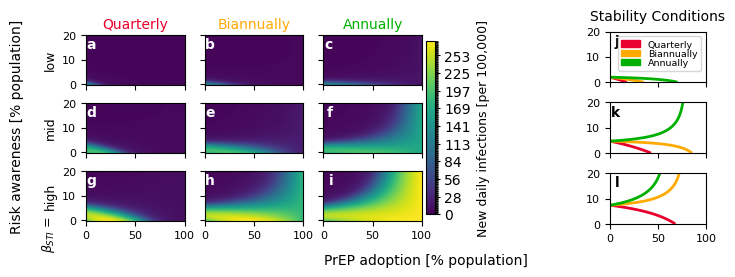

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap, BoundaryNorm

# First figure data generation (3x3)
Hs = np.linspace(0, 0.2, 101)
Ps = np.linspace(0, 1.0, 201)

lambda_P_values = [4 / 360.0, 2 / 360.0, 1 / 360.0]
lambda_P_labels = ["Quarterly", "Biannually", "Annually"]
beta_STI_values = [0.0016 * 3.0, 0.0016 * 5.0, 0.0016 * 7.0]
beta_STI_labels = ["low", "mid", "high"]

results = {}
for beta_STI in beta_STI_values:
    args["beta_STI"] = beta_STI
    for lambda_P in lambda_P_values:
        result = np.zeros((len(Hs), len(Ps)))
        for i, H in enumerate(Hs):
            for j, P in enumerate(Ps):
                if R0(P, H, args, lambda_P) <1000000 :
                    #print(P,H,calculate_S(P, H, args, lambda_P))
                    result[i, j] = (
                        beta_STI
                        * ((1 - m(P, H, args)) * (1 - P) + P)
                        * calculate_S(P, H, args, lambda_P)
                        * (
                            calculate_Ia(P, H, args, lambda_P)+calculate_Is(P, H, args, lambda_P)
                        ) + args["Sigma"]
                    )
        results[(beta_STI, lambda_P)] = result


all_infections = np.concatenate(
    [
        results[(beta_STI, lambda_P)].flatten()
        for beta_STI in beta_STI_values
        for lambda_P in lambda_P_values
    ]
)
global_vmin = np.nanmin(all_infections)
global_vmax = np.nanmax(all_infections)
#print(global_vmax*100000)
# Replace all values less than 0 with nan
'''for key in results:
    results[key] = np.where(results[key] < 0, np.nan, results[key])'''

import matplotlib.colors as mcolors
# Adjust the colormap
cmap = plt.get_cmap('viridis')  # Or whatever cmap you want
cmaplist = [cmap(i) for i in range(cmap.N)]
cmaplist[0] = (0, 0, 0, 1.0)  # making the first color of the colormap black
cmap = mcolors.LinearSegmentedColormap.from_list('mymap', cmaplist, cmap.N)

# Normalize the color map to the data range
norm = BoundaryNorm(np.linspace(0, global_vmax, cmap.N), cmap.N)

# Second figure data generation (3x1)
def bifurcationP(
    betaSTI,
    lambda_0=args["lambda_s"],
    mu=args["mu"],
    gamma=args["gamma_STI"],
    psi=args["psi"],
):
    lambdap = (
        psi * (lambda_0 + mu) / ((lambda_0 + mu) / betaSTI - (1 - psi)) - mu - gamma
    )
    return lambdap


lambda_P_values_2 = [
    4 / 360.0,
    2 / 360.0,
    1 / 360.0,
]
lambda_P_labels_2 = ["Quarterly", "Biannually", "Annually"]

colors = plt.cm.viridis(np.linspace(0, 1, len(lambda_P_values_2)))
colors_stability = ["#E9002D", "#FFAA00", "#00B000"]

# Combined plotting
fig = plt.figure(figsize=(8.0, 2.5))

# Adjust width ratios to control the size of the panels
outer_grid = fig.add_gridspec(1, 2, width_ratios=[2.5, 0.6], wspace=0.5)

# First subplot grid (3x3)
left_grid = outer_grid[0].subgridspec(3, 3, wspace=0.2, hspace=0.2)

axes = []
for i in range(3):
    row_axes = []
    for j in range(3):
        ax = fig.add_subplot(left_grid[i, j])
        row_axes.append(ax)
    axes.append(row_axes)

for row_idx, beta_STI in enumerate(beta_STI_values):
    for col_idx, (lambda_P, label) in enumerate(zip(lambda_P_values, lambda_P_labels)):
        ax = axes[row_idx][col_idx]
        res_infections = np.where(results[(beta_STI, lambda_P)]<0, 0, results[(beta_STI, lambda_P)])
        #res_infections = results[(beta_STI, lambda_P)]
        cax = ax.imshow(
            res_infections, origin="lower", cmap=cmap, norm=norm
        )
        cax.cmap.set_bad('black')
        if row_idx == 0:
            ax.set_title(
                f"{label}", fontsize=10, pad=5, color=colors_stability[col_idx]
            )
        if col_idx == 0:
            ax.set_ylabel(f"{beta_STI_labels[row_idx]}", fontsize=9)

        # ax.hlines(np.where(Hs == 0.05)[0][0], 0, 200, color="black", linestyle="--")

        if row_idx == 2:
            ax.set_xticks([0, 100, 200])
            ax.set_xticklabels(
                [int(Ps[0] * 100), int(Ps[100] * 100), int(Ps[200] * 100)], fontsize=8
            )
        else:
            ax.set_xticks([0, 100, 200])
            ax.set_xticklabels([])

        if col_idx == 0:
            ax.set_yticks([0, 50, 100])
            ax.set_yticklabels(
                [int(Hs[0] * 100), int(Hs[50] * 100), int(Hs[100] * 100)], fontsize=8
            )
        else:
            ax.set_yticks([0, 50, 100])
            ax.set_yticklabels([])

# Add subpanel letters
for idx, ax in enumerate([ax for row_axes in axes for ax in row_axes]):
    ax.text(
        0.1,
        0.95,
        chr(97 + idx),
        transform=ax.transAxes,
        fontsize=10,
        fontweight="bold",
        va="top",
        ha="right",
        color="white",
    )

# Color bar for first subplot
cbar = fig.colorbar(
    cax,
    ax=[ax for row_axes in axes for ax in row_axes],
    shrink=0.9,
    format=FuncFormatter(lambda x, pos: f"{x * 1e5:.0f}"),
    pad=0.01,
)
# Get existing ticks and replace the last value with global_vmax
# ticks = cbar.get_ticks()
# ticks[-1] = global_vmax
# cbar.set_ticks(ticks)

cbar.ax.set_ylabel("New daily infections [per 100,000]", fontsize=9)

fig.text(0.55, -0.05, "PrEP adoption [% population]", ha="center", fontsize=10)
fig.text(
    0.03,
    0.5,
    "Risk awareness [% population]",
    va="center",
    rotation="vertical",
    fontsize=10,
)
fig.text(
    0.067, 0.07, "$\\beta_{{STI}}$ =", va="center", rotation="vertical", fontsize=9
)

# Second subplot grid (3x1)
right_grid = outer_grid[1].subgridspec(3, 1, hspace=0.4)

axs = []
for i in range(3):
    ax = fig.add_subplot(right_grid[i])
    axs.append(ax)


for ax, betaSTI in zip(axs, beta_STI_values):
    args["beta_STI"] = betaSTI
    # bifur = bifurcationP(betaSTI)
    for lambda_P, color in zip(lambda_P_values_2, colors_stability):
        Ro_values = np.zeros((len(Hs), len(Ps)))
        for i, H in enumerate(Hs):
            for j, P in enumerate(Ps):
                Ro_values[i, j] = R0(P, H, args, lambda_P)
        ax.contour(
            Ps,
            Hs,
            Ro_values,
            levels=[1],
            linewidths=2,
            linestyles="-",
            colors=[color],
        )

    axs[0].set_title("Stability Conditions", fontsize=10, pad=8)
    ax.set_xticks(np.linspace(Ps.min(), Ps.max(), 3))
    ax.set_xticklabels(
        [f"{int(p * 100)}" for p in np.linspace(Ps.min(), Ps.max(), 3)], fontsize=8
    )
    ax.set_yticks([Hs[0], Hs[50], Hs[100]])
    ax.set_yticklabels(
        [int(Hs[0] * 100), int(Hs[50] * 100), int(Hs[100] * 100)], fontsize=8
    )

for ax in axs[:-1]:
    ax.set_xticklabels([])

legend_patches = [
    Patch(color=color, label=label)
    for color, label in zip(colors_stability, lambda_P_labels_2)
]
legend = axs[0].legend(
    handles=legend_patches,
    # title="$\\lambda_P$ values",
    fontsize=6.8,
    title_fontsize=5,
    loc="upper right",
    ncol=1,
    labelspacing=0.02,
)
# legend.get_frame().set_facecolor("white")
# legend.get_frame().set_alpha(1)

letters = ["j", "k", "l"]
for idx, ax in enumerate(axs):
    ax.text(
        0.1,
        0.95,
        chr(97 + 9 + idx),
        transform=ax.transAxes,
        fontsize=10,
        fontweight="bold",
        va="top",
        ha="right",
    )

#print(global_vmax*100000)
plt.tight_layout()
plt.show()



In [10]:
results[(0.0016*7, 4/360)][0,:]*100000

array([195.59246686, 198.99531352, 202.31982542, 205.56616938,
       208.73451165, 211.82501784, 214.83785304, 217.7731817 ,
       220.63116773, 223.41197444, 226.11576458, 228.74270032,
       231.29294328, 233.76665449, 236.16399443, 238.48512302,
       240.73019962, 242.89938304, 244.99283153, 247.0107028 ,
       248.95315401, 250.82034178, 252.61242217, 254.32955074,
       255.97188247, 257.53957184, 259.03277277, 260.45163868,
       261.79632246, 263.06697645, 264.26375249, 265.38680191,
       266.43627551, 267.41232358, 268.31509589, 269.14474172,
       269.90140984, 270.5852485 , 271.19640547, 271.73502799,
       272.20126285, 272.5952563 , 272.91715413, 273.16710163,
       273.34524358, 273.45172432, 273.48668766, 273.45027697,
       273.34263512, 273.16390451, 272.91422706, 272.59374421,
       272.20259697, 271.74092583, 271.20887085, 270.60657163,
       269.93416728, 269.19179647, 268.37959742, 267.49770788,
       266.54626515, 265.5254061 , 264.43526713, 263.27

C:\Users\PMallick\AppData\Local\Temp\ipykernel_24656\1074585724.py:187: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


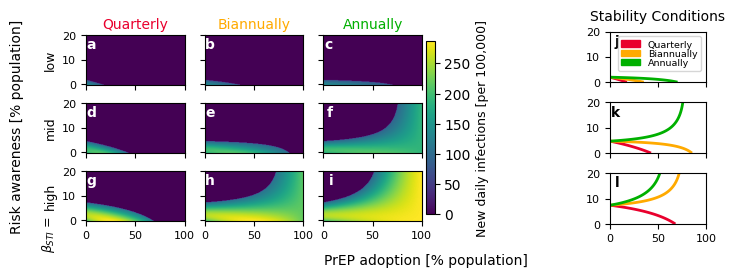

In [6]:
# Second figure data generation (3x1)
def bifurcationP(
    betaSTI,
    lambda_0=args["lambda_s"],
    mu=args["mu"],
    gamma=args["gamma_STI"],
    psi=args["psi"],
):
    lambdap = (
        psi * (lambda_0 + mu) / ((lambda_0 + mu) / betaSTI - (1 - psi)) - mu - gamma
    )
    return lambdap


lambda_P_values_2 = [
    4 / 360.0,
    2 / 360.0,
    1 / 360.0,
]
lambda_P_labels_2 = ["Quarterly", "Biannually", "Annually"]

colors = plt.cm.viridis(np.linspace(0, 1, len(lambda_P_values_2)))
colors_stability = ["#E9002D", "#FFAA00", "#00B000"]

# Combined plotting
fig = plt.figure(figsize=(8.0, 2.5))

# Adjust width ratios to control the size of the panels
outer_grid = fig.add_gridspec(1, 2, width_ratios=[2.5, 0.6], wspace=0.5)

# First subplot grid (3x3)
left_grid = outer_grid[0].subgridspec(3, 3, wspace=0.2, hspace=0.2)

axes = []
for i in range(3):
    row_axes = []
    for j in range(3):
        ax = fig.add_subplot(left_grid[i, j])
        row_axes.append(ax)
    axes.append(row_axes)

for row_idx, beta_STI in enumerate(beta_STI_values):
    for col_idx, (lambda_P, label) in enumerate(zip(lambda_P_values, lambda_P_labels)):
        ax = axes[row_idx][col_idx]
        res_infections = results[(beta_STI, lambda_P)]
        cax = ax.imshow(
            res_infections, origin="lower", vmin=global_vmin, vmax=global_vmax
        )
        if row_idx == 0:
            ax.set_title(
                f"{label}", fontsize=10, pad=5, color=colors_stability[col_idx]
            )
        if col_idx == 0:
            ax.set_ylabel(f"{beta_STI_labels[row_idx]}", fontsize=9)

        # ax.hlines(np.where(Hs == 0.05)[0][0], 0, 200, color="black", linestyle="--")

        if row_idx == 2:
            ax.set_xticks([0, 100, 200])
            ax.set_xticklabels(
                [int(Ps[0] * 100), int(Ps[100] * 100), int(Ps[200] * 100)], fontsize=8
            )
        else:
            ax.set_xticks([0, 100, 200])
            ax.set_xticklabels([])

        if col_idx == 0:
            ax.set_yticks([0, 50, 100])
            ax.set_yticklabels(
                [int(Hs[0] * 100), int(Hs[50] * 100), int(Hs[100] * 100)], fontsize=8
            )
        else:
            ax.set_yticks([0, 50, 100])
            ax.set_yticklabels([])

# Add subpanel letters
for idx, ax in enumerate([ax for row_axes in axes for ax in row_axes]):
    ax.text(
        0.1,
        0.95,
        chr(97 + idx),
        transform=ax.transAxes,
        fontsize=10,
        fontweight="bold",
        va="top",
        ha="right",
        color="white",
    )

# Color bar for first subplot
cbar = fig.colorbar(
    cax,
    ax=[ax for row_axes in axes for ax in row_axes],
    shrink=0.9,
    format=FuncFormatter(lambda x, pos: f"{x * 1e5:.0f}"),
    pad=0.01,
)
# Get existing ticks and replace the last value with global_vmax
# ticks = cbar.get_ticks()
# ticks[-1] = global_vmax
# cbar.set_ticks(ticks)

cbar.ax.set_ylabel("New daily infections [per 100,000]", fontsize=9)

fig.text(0.55, -0.05, "PrEP adoption [% population]", ha="center", fontsize=10)
fig.text(
    0.03,
    0.5,
    "Risk awareness [% population]",
    va="center",
    rotation="vertical",
    fontsize=10,
)
fig.text(
    0.067, 0.07, "$\\beta_{{STI}}$ =", va="center", rotation="vertical", fontsize=9
)

# Second subplot grid (3x1)
right_grid = outer_grid[1].subgridspec(3, 1, hspace=0.4)

axs = []
for i in range(3):
    ax = fig.add_subplot(right_grid[i])
    axs.append(ax)


for ax, betaSTI in zip(axs, beta_STI_values):
    args["beta_STI"] = betaSTI
    # bifur = bifurcationP(betaSTI)
    for lambda_P, color in zip(lambda_P_values_2, colors_stability):
        Ro_values = np.zeros((len(Hs), len(Ps)))
        for i, H in enumerate(Hs):
            for j, P in enumerate(Ps):
                Ro_values[i, j] = R0(P, H, args, lambda_P)
        ax.contour(
            Ps,
            Hs,
            Ro_values,
            levels=[1],
            linewidths=2,
            linestyles="-",
            colors=[color],
        )

    axs[0].set_title("Stability Conditions", fontsize=10, pad=8)
    ax.set_xticks(np.linspace(Ps.min(), Ps.max(), 3))
    ax.set_xticklabels(
        [f"{int(p * 100)}" for p in np.linspace(Ps.min(), Ps.max(), 3)], fontsize=8
    )
    ax.set_yticks([Hs[0], Hs[50], Hs[100]])
    ax.set_yticklabels(
        [int(Hs[0] * 100), int(Hs[50] * 100), int(Hs[100] * 100)], fontsize=8
    )

for ax in axs[:-1]:
    ax.set_xticklabels([])

legend_patches = [
    Patch(color=color, label=label)
    for color, label in zip(colors_stability, lambda_P_labels_2)
]
legend = axs[0].legend(
    handles=legend_patches,
    # title="$\\lambda_P$ values",
    fontsize=6.8,
    title_fontsize=5,
    loc="upper right",
    ncol=1,
    labelspacing=0.02,
)
# legend.get_frame().set_facecolor("white")
# legend.get_frame().set_alpha(1)

letters = ["j", "k", "l"]
for idx, ax in enumerate(axs):
    ax.text(
        0.1,
        0.95,
        chr(97 + 9 + idx),
        transform=ax.transAxes,
        fontsize=10,
        fontweight="bold",
        va="top",
        ha="right",
    )

plt.tight_layout()
plt.show()


In [6]:
import numpy as np

def kappa(P, H, args):
    return args['beta_STI'] * (1 - m(P, H, args) * (1 - P))

def lambdas(P, H, args):
    return args["lambda_s"] + lambdaa(P, H, args)

def lambdaa(P, H, args, lambda_P):
    return lambdaH(P, H, args) * (1 - P) + lambda_P * P

def lambdaH(P, H, args):
    return args["c"] * (1 - m(P, H, args)) * args["beta_HIV"] * H

def m(P, H, args):
    return args["min_exp"] + (args["max_exp"] - args["min_exp"]) * (1 - np.exp(-H / args["tau_exp"]))

def calculate_Ia_Is_S(P, H, args):
    gamma, tilde_gamma, mu, psi, Sigma = args["gamma_STI"], args["gammaT_STI"], args["mu"], args["psi"], args["Sigma"]
    kappa_val = kappa(P, H, args)
    lambda_s_val = lambdas(P, H, args)
    lambda_a_val = lambdaa(P, H, args)

    C = (gamma + lambda_a_val + mu) * (1 - psi) / (psi * (lambda_s_val + mu))
    A = gamma - (1 - psi) * (lambda_s_val + mu) * C - tilde_gamma * (1 + C)
    B = tilde_gamma + mu - ((tilde_gamma + mu) * (lambda_s_val + mu) * C) / ((1 - psi) * kappa_val * (1 + C))
    C_prime = (tilde_gamma + mu) * Sigma / (kappa_val * (1 + C))

    discriminant = B**2 - 4 * A * C_prime
    if discriminant < 0:
        raise ValueError("Discriminant is negative, no real roots exist.")

    Ia_star = (-B - np.sqrt(discriminant)) / (2 * A)
    Is_star = C * Ia_star
    S_star = ((lambda_s_val + mu) * C * Ia_star - (1 - psi) * Sigma) / ((1 - psi) * kappa_val * (1 + C) * Ia_star)

    return Ia_star, Is_star, S_star

Ps = np.linspace(0, 1, 10)
Hs = np.linspace(0.0, 0.2, 10)
for P in Ps:
    for H in Hs:
        Ia_star, Is_star, S_star = calculate_Ia_Is_S(P, H, args)
        print("P",P,"H",H,"Ia*:", Ia_star, "Is*:", Is_star, "S*:", S_star)

P 0.0 H 0.0 Ia*: 0.784160181317212 Is*: 0.004192852700582465 S*: 0.223219057479062
P 0.0 H 0.022222222222222223 Ia*: 0.5521140675950673 Is*: 0.005211235388029023 S*: 0.4506443032381134
P 0.0 H 0.044444444444444446 Ia*: 0.32316671471911457 Is*: 0.004050622796671509 S*: 0.677365135384484
P 0.0 H 0.06666666666666667 Ia*: 0.10990879251895301 Is*: 0.0016329521896488743 S*: 0.8899950246117103
P 0.0 H 0.08888888888888889 Ia*: 0.020965388180393823 Is*: 0.00034746959046068386 S*: 0.9789771457199733
P 0.0 H 0.11111111111111112 Ia*: 0.010221843599193961 Is*: 0.00018202522115351186 S*: 0.9897364036008149
P 0.0 H 0.13333333333333333 Ia*: 0.007161310055025965 Is*: 0.000133598726145376 S*: 0.9928028175085368
P 0.0 H 0.15555555555555556 Ia*: 0.005780974030333499 Is*: 0.00011095753944440645 S*: 0.9941866755149833
P 0.0 H 0.17777777777777778 Ia*: 0.0050265394261551095 Is*: 9.792498704830644e-05 S*: 0.994943751976358
P 0.0 H 0.2 Ia*: 0.004573762921462474 Is*: 8.950098668625505e-05 S*: 0.9953987714111132


In [11]:
import numpy as np

def kappa(P, H, args):
    return args['beta_STI'] * (1 - m(P, H, args) * (1 - P))

def lambdas(P, H, args):
    return args["lambda_s"] + lambdaa(P, H, args)

def lambdaa(P, H, args, lambda_P):
    return lambdaH(P, H, args) * (1 - P) + lambda_P * P

def lambdaH(P, H, args):
    return args["c"] * (1 - m(P, H, args)) * args["beta_HIV"] * H

def m(P, H, args):
    return args["min_exp"] + (args["max_exp"] - args["min_exp"]) * (1 - np.exp(-H / args["tau_exp"]))

def calculate_Ia_Is_S(P, H, args):
    gamma, tilde_gamma, mu, psi, Sigma = args["gamma_STI"], args["gammaT_STI"], args["mu"], args["psi"], args["Sigma"]
    kappa_val = kappa(P, H, args)
    lambda_s_val = lambdas(P, H, args)
    lambda_a_val = lambdaa(P, H, args)

    C = (gamma + lambda_a_val + mu) * (1 - psi) / (psi * (lambda_s_val + mu))
    A = gamma - (1 - psi) * (lambda_s_val + mu) * C - tilde_gamma * (1 + C)
    B = tilde_gamma + mu - ((tilde_gamma + mu) * (lambda_s_val + mu) * C) / ((1 - psi) * kappa_val * (1 + C))
    C_prime = (tilde_gamma + mu) * Sigma / (kappa_val * (1 + C))
    #print("A",A,"B",B,"C",C,"C'",C_prime)

    discriminant = B**2 - 4 * A * C_prime
    if discriminant < 0:
        raise ValueError("Discriminant is negative, no real roots exist.")

    Ia_star = (-B - np.sqrt(discriminant)) / (2 * A)
    Is_star = C * Ia_star
    S_star = ((lambda_s_val + mu) * C * Ia_star - (1 - psi) * Sigma) / ((1 - psi) * kappa_val * (1 + C) * Ia_star)

    return Ia_star, Is_star, S_star

def R0(P, H, args):
    return args["psi"] * (args['beta_STI'] * (1 - m(P, H, args) * (1 - P))) / (args["gamma_STI"] + lambdaa(P, H, args) + args["mu"]) + (1 - args["psi"]) * (args['beta_STI'] * (1 - m(P, H, args) * (1 - P))) / (lambdas(P, H, args) + args["mu"])

Ps = np.linspace(0, 1, 10)
Hs = np.linspace(0.0, 0.2, 10)
for P in Ps:
    for H in Hs:
        if R0(P, H, args) > 1:
            Ia_star, Is_star, S_star = calculate_Ia_Is_S(P, H, args)
            print("P",P,"H",H,"Ia*:", Ia_star, "Is*:", Is_star, "S*:", S_star)

P 0.0 H 0.0 Ia*: 0.6896390130944065 Is*: 0.0036874542566325535 S*: 0.31685074637323435
P 0.0 H 0.022222222222222223 Ia*: 0.3640498331108809 Is*: 0.0034361547452996504 S*: 0.6377689657577142
P 0.0 H 0.044444444444444446 Ia*: 0.03868201558645898 Is*: 0.00048484651116343996 S*: 0.9613816451590944
P 0.1111111111111111 H 0.0 Ia*: 0.6438151501713211 Is*: 0.0039160332610446704 S*: 0.36173319450020625
P 0.1111111111111111 H 0.022222222222222223 Ia*: 0.3539579262608499 Is*: 0.003432824402267301 S*: 0.6477110917371428
P 0.1111111111111111 H 0.044444444444444446 Ia*: 0.07152056215384413 Is*: 0.0008902237338263856 S*: 0.928603890772442
P 0.2222222222222222 H 0.0 Ia*: 0.59813182060724 Is*: 0.004074386971311218 S*: 0.40655260076095
P 0.2222222222222222 H 0.022222222222222223 Ia*: 0.3441348860487846 Is*: 0.003426652170246754 S*: 0.6573914866688602
P 0.2222222222222222 H 0.044444444444444446 Ia*: 0.10264562952545457 Is*: 0.0012686951689514162 S*: 0.8975426787118659
P 0.3333333333333333 H 0.0 Ia*: 0.55

In [ ]:

def f(P,H):
    return (lambdas(P,H)+args["mu"]) / (1-args["psi"])
def Splus(P,H):
    if R0(P,H) < 1:
        return 1
    else:
        return (f(P,H)*Iaplus(P,H)*c(P,H)-args['Sigma']) / (kappa(P,H)*Iaplus(P,H)*(1+c(P,H)))
def Sminus(P,H):
    if R0(P,H) < 1:
        return 1
    else:
        return (f(P,H)*Iaminus(P,H)*c(P,H)-args['Sigma']) / (kappa(P,H)*Iaminus(P,H)*(1+c(P,H)))
def c(P,H):
    return ((1-args['psi'])*(args['gamma_STI']+lambdaa(P,H)+args['mu'])) / (args['psi']*(lambdas(P,H)+args['mu']))
def Iaplus(P,H):
    return (-bL(P,H) + np.sqrt(bL(P,H)**2 - 4*aL(P,H)*dL(P,H))) / (2*aL(P,H))
def Iaminus(P,H):
    return (-bL(P,H) - np.sqrt(bL(P,H)**2 - 4*aL(P,H)*dL(P,H))) / (2*aL(P,H))
def aL(P,H):
    return kappa(P,H) * (args['gamma_STI']-args['gammaT_STI']+c(P,H)**2*(-f(P,H)-args['gammaT_STI'])+c(P,H)*(-f(P,H)+args['gamma_STI']-2*args['gammaT_STI']))
def bL(P,H):
    return kappa(P,H)*(args['gammaT_STI']+args['mu'])*(1+c(P,H))+c(P,H)*(args['mu']-args['gammaT_STI'])*f(P,H)
def dL(P,H):
    return args['Sigma']*(args['mu']-args['gammaT_STI'])
def kappa(P,H):
    return args['beta_STI'] * (1-m(P,H)*(1-P))
def lambdas(P, H):
    return args["lambda_s"] + lambdaa(P, H)
def lambdaa(P, H):
    return lambdaH(P, H) * (1 - P) + lambdaP * P
def lambdaH(P, H):
    return args["c"] * (1 - m(P, H)) * args["beta_HIV"] * H
def m(P, H):
    return args["min_exp"] + (args["max_exp"] - args["min_exp"]) * (1 - jnp.exp(-H / args["tau_exp"]))
def R0(P, H):
    return args["psi"] * (args['beta_STI'] * (1 - m(P, H) * (1 - P))) / (args["gamma_STI"] + lambdaa(P, H) + args["mu"]) + (1 - args["psi"]) * (args['beta_STI'] * (1 - m(P, H) * (1 - P))) / (lambdas(P, H) + args["mu"])
Ps = np.linspace(0, 1, 10)
Hs = np.linspace(0, 0.2, 10)
for P in Ps:
    for H in Hs:
        if True:#((Splus(P,H) < 0) or (Splus(P,H) > 1)):
            print("P: ",P," H: ",H, "sum: ",np.sum([Iaplus(P,H),Splus(P,H),Sminus(P,H)]) ,"Iaplus:", Iaplus(P,H),"Splus:", Splus(P,H))
        if True:
            print("P: ",P," H: ",H, "sum: ",np.sum([Iaplus(P,H),Splus(P,H),Sminus(P,H)]) ,"Iaminus:", Iaminus(P,H), "Sminus:", Sminus(P,H))

## Fixed points Calculation (New)

In [19]:
lambdaP = 1 / 360  # 1,2,4
betaSTI = 0.008  # 0.0016 *[3, 5, 7]
def Splus(P,H):
    if R0(P,H) < 1:
        return 1
    else:
        return (D(P,H)*Iaplus(P,H)+args["Phi"]-args["Sigma"])/(kappa(P,H)*(1+C(P,H))*Iaplus(P,H)+args["mu"])
def Sminus(P,H):
    if R0(P,H) < 1:
        return 1
    else:
        return (D(P,H)*Iaminus(P,H)+args["Phi"]-args["Sigma"])/(kappa(P,H)*(1+C(P,H))*Iaminus(P,H)+args["mu"])

def C(P,H):
    return ((args["gamma_STI"]+lambdaa(P,H)+args["mu"])*(1-args['psi']))/(args["psi"]*(lambdas(P, H)+args["mu"]))

def D(P,H):
    return args["gamma_STI"]+ (args["gammaT_STI"]*(lambdaa(P,H)+lambdas(P,H)*C(P,H)))/(args["gammaT_STI"]+args["mu"])

def a(P,H):
    return kappa(P,H)*(1+C(P,H))*(D(P,H)-(args["gamma_STI"]+args["mu"]+lambdaa(P,H))/args["psi"])

def b(P,H):
    return kappa(P,H)*(1+C(P,H))*args["Phi"]-((args["gamma_STI"]+args["mu"]+lambdaa(P,H))/args["psi"])*args["mu"]

def d(P,H):
    return args["Sigma"]*args["mu"]

def kappa(P,H):
    return args['beta_STI'] * (1-m(P,H)*(1-P))
def lambdas(P, H):
    return args["lambda_s"] + lambdaa(P, H)
def lambdaa(P, H):
    return lambdaH(P, H) * (1 - P) + lambdaP * P
def lambdaH(P, H):
    return args["c"] * (1 - m(P, H)) * args["beta_HIV"] * H
def m(P, H):
    return args["min_exp"] + (args["max_exp"] - args["min_exp"]) * (1 - jnp.exp(-H / args["tau_exp"]))
def R0(P, H):
    return args["psi"] * (args['beta_STI'] * (1 - m(P, H) * (1 - P))) / (args["gamma_STI"] + lambdaa(P, H) + args["mu"]) + (1 - args["psi"]) * (args['beta_STI'] * (1 - m(P, H) * (1 - P))) / (lambdas(P, H) + args["mu"])

def Iaminus(P, H):
    if R0(P, H) < 1:
        return 0
    else:
        return -b(P, H) + jnp.sqrt(b(P, H) ** 2 - 4 * a(P, H) * d(P, H)) / (2 * a(P, H))

def Iaplus(P, H):
    if R0(P, H) < 1:
        return 0
    else:
        return -b(P, H) - jnp.sqrt(b(P, H) ** 2 - 4 * a(P, H) * d(P, H)) / (2 * a(P, H))

def Isminus(P, H):
    if R0(P, H) < 1:
        return 0
    else:
        return C(P, H) * Iaminus(P, H)

def Isplus(P, H):
    if R0(P, H) < 1:
        return 0
    else:
        return C(P, H) * Iaplus(P, H)

def Tminus(P, H):
    if R0(P, H) < 1:
        return 0
    else:
        return ((lambdaa(P, H) + lambdas(P, H) * C(P, H))/(args["mu"]+args["gammaT_STI"])) * Iaminus(P, H)

def Tplus(P, H):
    if R0(P, H) < 1:
        return 0
    else:
        return ((lambdaa(P, H) + lambdas(P, H) * C(P, H))/(args["mu"]+args["gammaT_STI"])) * Iaplus(P, H)

Ps = np.linspace(0, 1, 10)
Hs = np.linspace(0, 0.2, 10)

for P in Ps:
    for H in Hs:
        if True:#((Splus(P,H) < 0) or (Splus(P,H) > 1)):
            print("P: ",P," H: ",H,"Total", Splus(P,H)+Iaplus(P,H)+Isplus(P,H)+Tplus(P,H), "Splus:", Splus(P,H),"Iaplus:", Iaplus(P,H), "Isplus:", Isplus(P,H), "Tplus:", Tplus(P,H))
        if True:
            print("P: ",P," H: ",H, "Sminus:", Sminus(P,H), "Iaminus:", Iaminus(P,H), "Isminus:", Isminus(P,H), "Tminus:", Tminus(P,H))

P:  0.0  H:  0.0 Total 0.6154772737069761 Splus: 0.22548151720540768 Iaplus: 0.38689316494659276 Isplus: 0.0020686922010733984 Tplus: 0.0010338993539022972
P:  0.0  H:  0.0 Sminus: 0.21597549458631568 Iaminus: -0.3868942404436606 Isminus: -0.0020686979516851903 Tminus: -0.0010339022279663135
P:  0.0  H:  0.022222222222222223 Total 0.7289306819078613 Splus: 0.45164673393890636 Iaplus: 0.2701189381866705 Isplus: 0.0025495698303554287 Tplus: 0.004615439951928936
P:  0.0  H:  0.022222222222222223 Sminus: 0.4468158286110139 Iaminus: -0.27011961819870806 Isminus: -0.002549576248780538 Tminus: -0.004615451571087322
P:  0.0  H:  0.044444444444444446 Total 0.8409600593649752 Splus: 0.6745876251890152 Iaplus: 0.1598192623024976 Isplus: 0.0020031999514318484 Tplus: 0.004549971922030669
P:  0.0  H:  0.044444444444444446 Sminus: 0.6851092105603503 Iaminus: -0.15981961353246887 Isminus: -0.0020032043538039486 Tminus: -0.004549981921366696
P:  0.0  H:  0.06666666666666667 Total 0.9483913443568849 Spl

## Fixed points Calculation (Old)

In [7]:
# test of new equations

def Splus(P,H):
    if R0(P,H) < 1:
        return 1
    else:
        return (-Bprime(P,H)+np.sqrt(Bprime(P,H)**2-4*Aprime(P,H)*Cprime(P,H)))/(2*Aprime(P,H))
def Sminus(P,H):
    if R0(P,H) < 1:
        return 1
    else:
        return (-Bprime(P,H)-np.sqrt(Bprime(P,H)**2-4*Aprime(P,H)*Cprime(P,H)))/(2*Aprime(P,H))

def Aprime(P,H):
    return kappa(P,H)*(a(P,H)+b(P,H)) * (C(P,H)*args['Sigma']-args['mu'])
def Bprime(P,H):
    return kappa(P,H)*(a(P,H)+b(P,H)) * (args['Phi']-C(P,H)*args['Sigma'])
def Cprime(P,H):
    return -(C(P,H)*args['Sigma']+args['Phi']-args['Sigma'])
def C(P,H):
    return args['gamma_STI']*a(P,H) + args['gammaT_STI']/(args['gammaT_STI']+args['mu']) * (lambdaa(P,H)*a(P,H) + lambdas(P,H)*b(P,H))
def a(P,H):
    return args['psi']/(args['gamma_STI']+lambdaa(P,H)+args['mu'])
def b(P,H):
    return (1-args['psi'])/(lambdas(P,H)+args['mu'])
def kappa(P,H):
    return args['beta_STI'] * (1-m(P,H)*(1-P))
def lambdas(P, H):
    return args["lambda_s"] + lambdaa(P, H)
def lambdaa(P, H):
    return lambdaH(P, H) * (1 - P) + lambdaP * P
def lambdaH(P, H):
    return args["c"] * (1 - m(P, H)) * args["beta_HIV"] * H
def m(P, H):
    return args["min_exp"] + (args["max_exp"] - args["min_exp"]) * (1 - jnp.exp(-H / args["tau_exp"]))
def R0(P, H):
    return args["psi"] * (args['beta_STI'] * (1 - m(P, H) * (1 - P))) / (args["gamma_STI"] + lambdaa(P, H) + args["mu"]) + (1 - args["psi"]) * (args['beta_STI'] * (1 - m(P, H) * (1 - P))) / (lambdas(P, H) + args["mu"])


Ps = np.linspace(0, 1, 10)
Hs = np.linspace(0, 0.2, 10)

for P in Ps:
    for H in Hs:
        if True:#((Splus(P,H) < 0) or (Splus(P,H) > 1)):
            print("P: ",P," H: ",H," S+: ", Splus(P,H))
            print(Aprime(P,H), Bprime(P,H), Cprime(P,H))
            print(kappa(P,H))
            print(Bprime(P,H)**2-4*Aprime(P,H)*Cprime(P,H))
        if True:#((Sminus(P,H) < 0) or (Sminus(P,H) > 1)):
            print("P: ",P," H: ",H," S-: ", Sminus(P,H))
            print(Aprime(P,H), Bprime(P,H), Cprime(P,H))
            print(Bprime(P,H)**2-4*Aprime(P,H)*Cprime(P,H))

C:\Users\PMallick\AppData\Local\Temp\ipykernel_30760\30790102.py:7: RuntimeWarning: invalid value encountered in sqrt
  return (-Bprime(P,H)+np.sqrt(Bprime(P,H)**2-4*Aprime(P,H)*Cprime(P,H)))/(2*Aprime(P,H))
C:\Users\PMallick\AppData\Local\Temp\ipykernel_30760\30790102.py:12: RuntimeWarning: invalid value encountered in sqrt
  return (-Bprime(P,H)-np.sqrt(Bprime(P,H)**2-4*Aprime(P,H)*Cprime(P,H)))/(2*Aprime(P,H))


P:  0.0  H:  0.0  S+:  nan
-0.00011046240340820063 0.00011046240340820063 -6.105943488341452e-05
0.008
-1.4777145145157914e-08
P:  0.0  H:  0.0  S-:  nan
-0.00011046240340820063 0.00011046240340820063 -6.105943488341452e-05
-1.4777145145157914e-08
P:  0.0  H:  0.022222222222222223  S+:  nan
-5.4420685369634144e-05 5.4420685369634144e-05 -6.135170562546664e-05
0.007158714534514958
-1.0393596478835021e-08
P:  0.0  H:  0.022222222222222223  S-:  nan
-5.4420685369634144e-05 5.4420685369634144e-05 -6.135170562546664e-05
-1.0393596478835021e-08
P:  0.0  H:  0.044444444444444446  S+:  nan
-3.600387638650991e-05 3.600387638650991e-05 -6.144606393691661e-05
0.006405899223334464
-7.552906846834237e-09
P:  0.0  H:  0.044444444444444446  S-:  nan
-3.600387638650991e-05 3.600387638650991e-05 -6.144606393691661e-05
-7.552906846834237e-09
P:  0.0  H:  0.06666666666666667  S+:  1
-2.6821323369926335e-05 2.6821323369926335e-05 -6.149107067809333e-05
0.005732250484590314
-5.87770417676639e-09
P:  0.0  H

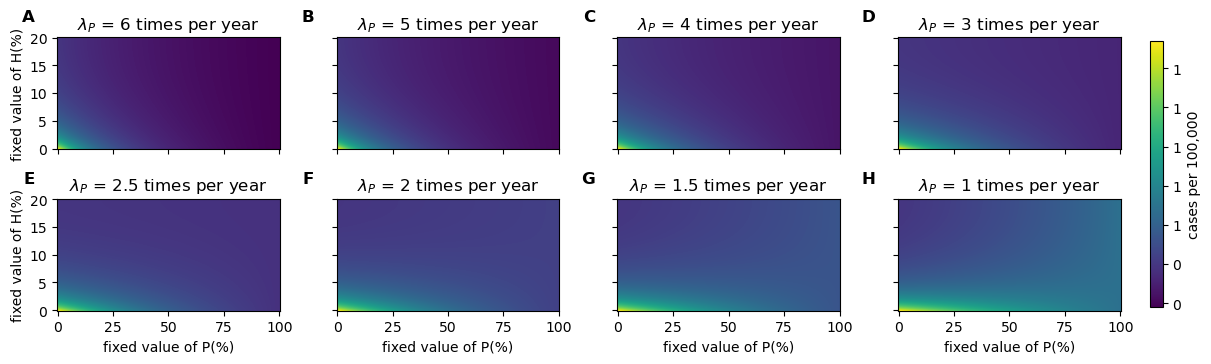

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Define parameters
args = {
    "beta_HIV": 0.6341 / 360.0,
    "beta_STI": 0.0016 * 5.0,
    "mu": 1.0 / 45.0 / 360.0,
    "gamma_STI": 1.0 / 1.32 / 360.0,
    "gammaT_STI": 1.0 / 14.0,
    "lambda_P": 1 / 3 / 360,
    "asymptomatic": 0.9,
    "m_max": 0.8,
    "H_thres": 0.1,
    "m_eps": 0.01,
    "Phi_r": 40.0,
    "H_tau": 0.2,
    "c": 50.0,
    "minexp": 0,
    "H": 0,
    "P_HIV": 0.0,
    "maxexp": 1,
}


# Mitigation function
def m(H, min_exp=args["minexp"], max_exp=args["maxexp"], tau_exp=args["H_tau"]):
    return min_exp + (max_exp - min_exp) * (1 - np.exp(-H / tau_exp))


# Define the equation for alpha
def alpha(P, H, beta_STI=args["beta_STI"]):
    return beta_STI * (1 - m(H) * (1 - P))


# Define the equation for I^{a,*}_{STI}
def I_star_STI(
    H,
    P,
    lam_P,
    beta_HIV=args["beta_HIV"],
    mu=args["mu"],
    gamma=args["gamma_STI"],
    C=args["c"],
    psi=args["asymptomatic"],
    tgamma=args["gammaT_STI"],
):
    P_star = P
    H_star = H
    m_star = m(H_star)
    alpha_val = alpha(P_star, H_star)

    term1 = (mu + tgamma) * (
        mu
        / (
            (
                psi
                * alpha_val
                * mu
                / (
                    gamma
                    + lam_P * P_star
                    + C * (1 - m_star) * beta_HIV * H_star * (1 - P_star)
                    + mu
                )
                + (1 - psi) * alpha_val
            )
            - 1
        )
    )
    term2 = (
        -(
            gamma
            + lam_P * P_star
            + C * (1 - m_star) * beta_HIV * H_star * (1 - P_star)
            + mu
        )
        / psi
    )
    term3 = gamma - tgamma * (
        (
            1
            + (
                gamma
                + lam_P * P_star
                + C * (1 - m_star) * beta_HIV * H_star * (1 - P_star)
                + mu
            )
            / mu
        )
        * (1 - psi)
        / psi
    )

    numerator = term1
    denominator = term2 + term3

    return numerator / denominator


# Define the ranges for H and P values
Hs = np.linspace(0, 0.2, 101)
Ps = np.linspace(0, 1.0, 201)

# Define different values for lambda_P
lambda_P_values = [
    6 / 360,
    5 / 360,
    4 / 360,
    3 / 360,
    2.5 / 360,
    2 / 360,
    1.5 / 360,
    1 / 360,
]

lambda_P_labels = [
    "6 times per year",
    "5 times per year",
    "4 times per year",
    "3 times per year",
    "2.5 times per year",
    "2 times per year",
    "1.5 times per year",
    "1 times per year",
]

# Calculate I_star_STI values for each combination of H, P, and lambda_P
results = {}
for lambda_P in lambda_P_values:
    I_values = np.zeros((len(Hs), len(Ps)))
    for i, H in enumerate(Hs):
        for j, P in enumerate(Ps):
            I_values[i, j] = I_star_STI(H, P, lambda_P)
    results[lambda_P] = I_values

# Determine the global vmin and vmax
all_infections = np.concatenate(
    [results[lambda_P].flatten() for lambda_P in lambda_P_values]
)
global_vmin = np.min(all_infections)
global_vmax = np.max(all_infections)

# Plotting
num_lambda_P = len(lambda_P_values)
gridspec = {
    "wspace": 0,
    "hspace": 0,
    "width_ratios": [1, 1, 1, 1],
    "height_ratios": [1, 1],
}
fig, axes = plt.subplots(
    2,
    num_lambda_P // 2,
    figsize=(3 * num_lambda_P // 2, 3.5),
    constrained_layout=True,
    gridspec_kw=gridspec,
)

nrows, ncols = axes.shape
for idx, lambda_P in enumerate(lambda_P_values):
    ax = axes.flat[idx]
    res_infections = results[lambda_P]
    cax = ax.imshow(res_infections, origin="lower", vmin=global_vmin, vmax=global_vmax)
    ax.set_title(f"$\\lambda_P$ = {lambda_P_labels[idx]}")

    # Determine the position of the subplot
    row, col = divmod(idx, ncols)

    # Set xlabels only on the bottom most subplots
    if row == nrows - 1:
        ax.set_xlabel("fixed value of P(%)")
        ax.set_xticks([0, 50, 100, 150, 200])
        ax.set_xticklabels(
            [
                int(Ps[0] * 100),
                int(Ps[50] * 100),
                int(Ps[100] * 100),
                int(Ps[150] * 100),
                int(Ps[200] * 100),
            ]
        )
    else:
        ax.set_xticklabels([])  # Hide xtick labels for non-bottom subplots

    # Set ylabels only on the left most subplots
    if col == 0:
        ax.set_ylabel("fixed value of H(%)")
        ax.set_yticks([0, 25, 50, 75, 100])
        ax.set_yticklabels(
            [
                int(Hs[0] * 100),
                int(Hs[25] * 100),
                int(Hs[50] * 100),
                int(Hs[75] * 100),
                int(Hs[100] * 100),
            ]
        )
    else:
        ax.set_yticks([0, 25, 50, 75, 100])
        ax.set_yticklabels([])  # Hide ytick labels for non-left subplots

    # Adding subpanel letters, adjust x and y positions as needed
    ax.text(
        -0.1,
        1.25,
        chr(65 + idx),
        transform=ax.transAxes,
        fontsize=12,
        fontweight="bold",
        va="top",
        ha="right",
    )


# Define a formatter function that multiplies the value by 100,000
def formatter(x, pos):
    return f"{x * 1e5:.0f}"


# Create a single color bar for the whole figure
cbar = fig.colorbar(
    cax,
    ax=axes.ravel().tolist(),
    shrink=0.88,
    format=FuncFormatter(formatter),
    pad=0.015,
)
cbar.ax.set_ylabel("cases per 100,000")

plt.show()

In [20]:
import numpy as np
from scipy.optimize import minimize

# Define the system of equations
def equations(vars):
 Ssti, Iasti, Issti, Tsti = vars
 eq1 = -beta_0_STI * (1 - m_H * (1 - P)) * (Iasti + Issti) * Ssti + gamma * Iasti + tilde_gamma * Tsti + Phi - mu * Ssti - Sigma
 eq2 = psi * beta_0_STI * (1 - m_H * (1 - P)) * (Iasti + Issti) * Ssti - gamma * Iasti - lambda_a_PH * Iasti - mu * Iasti + psi * Sigma
 eq3 = (1 - psi) * beta_0_STI * (1 - m_H * (1 - P)) * (Iasti + Issti) * Ssti - lambda_s_PH * Issti - mu * Issti + (1 - psi) * Sigma
 eq4 = lambda_a_PH * Iasti + lambda_s_PH * Issti - tilde_gamma * Tsti - mu * Tsti
 return np.array([eq1, eq2, eq3, eq4])

# Define the constraint S+I+T=1
def constraint(vars):
 Ssti, Iasti, Issti, Tsti = vars
 return Ssti + Iasti + Issti + Tsti - 1

# Initial guess
x0 = np.array([1, 0.001, 0.0, 0.0])

# Define the bounds for the variables
bounds = [(0, 1), (0, 1), (0, 1), (0, 1)]

# Define the constraints
con = {'type': 'eq', 'fun': constraint}

# Solve the system of equations with the constraint
sol = minimize(lambda x: np.sum(equations(x)**2), x0, method='SLSQP', bounds=bounds, constraints=con)

print(sol.x)


[0.00000000e+00 1.00000000e+00 0.00000000e+00 8.32667268e-16]
